# STEP 3: Finetuning LernnaviBERT on MCQs students' answers prediction

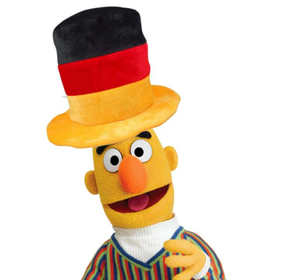

[Source of the image: https://huggingface.co/bert-base-german-cased]

In order to transform a pretrained GermanBERT model in a model able to predict the students’ answers to Multiple Choice Questions (MCQs), we decided to follow a pipeline made of three steps:
1. Finetuning GermanBERT on language modelling considering the Lernnavi dataset. The finetuned model will be renamed "LernnaviBERT" for clarity;
2. Finetuning LernnaviBERT to predict the correct answers to MCQs;
3. Further finetuning the model on the final downstream task, that is the prediction of the answers of a given student to MCQs, taking into account the embedding of the student.

In this notebook, we will perform the third step, that is finetuning MCQBert to predict the answers of the various students to MCQs, taking into account the embeddings. In particular, we will follow a procedure very similar to the one followed in the second step, but this time we will also consider the student embeddings (and we are not interested in predicting the correct answers). We will start by introducing some models based on LernnaviBERT, finetuned on predicting the correct answers to MCQs. Then, we will train the models on a training dataset, and verify the performances on a test dataset.

## Theoretical motivation

In the third and final step, we aim at finetuning the model on the final downstream task, that is predicting the answers given by students to MCQs taking into account some information from the students (in the form of embeddings). Our hypothesis is that the model can benefit from the finetuning performed in the previous steps (language modelling task and MCQs correct answer prediction) to predict the students' answers in a more accurate way.

## STEP 3

We then define a set of variables that we will need during the finetuning process.

In [1]:
BASE_DATA_DIR = "../../data"
QNA_DATA_DIR = f"{BASE_DATA_DIR}/lernnavi/qna"
ORIGINAL_DATA_DIR = f"{BASE_DATA_DIR}/original/data"

never_seen_MCQ = False
train_ratio = 0.8
splitting_tolerance = 0.02
batch_size = 16
epochs = 3
max_gradient_norm = 1.0
warmup_p = 0.3
learning_rate = 1.75e-5

Then, we import all the packages which are necessary to run the notebook.

In [2]:
import pickle
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from dataset_train_eval_extensions import QuestionsDatasetWithSyncedEmbeddings, train, generate_synced_qna_embeddings
import torch
from transformers import BertModel, AutoTokenizer, AutoConfig
import numpy as np 
import random
from huggingface_hub import notebook_login

/tmp/ipykernel_8469/4242358378.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Since we want to push the finetuned models to HuggingFace Hub, we have to login to the Hub using HuggingFace token. It should be noted that this cell must be run alone (i.e. the cells should not be run all together up to here), otherwise it would be impossible to insert the token and to login successfully.

In [3]:
notebook_login()

At this point, we fix the random seed for reproducibility purposes. It should be noted, in any case, that the randomness is not completely removed, and the results may vary from run to run.

In [4]:
seed = int(0)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
print('Random seed (for reproducibility): ', seed)

Random seed (for reproducibility):  0


We load the dataset containing all the Lernnavi MCQs (questions and possible answers).

In [5]:
# with open('/content/drive/MyDrive/MLBD/datasets/Lernnavi_MCQs.pkl', 'rb') as file:
seq_len = 10
data = generate_synced_qna_embeddings(
    f'{QNA_DATA_DIR}/all_data_qna_expanded.pkl',
    f'{QNA_DATA_DIR}/embeddings/mistral_seq_len_{seq_len}.pt',
    f'{QNA_DATA_DIR}/MULTIPLE_CHOICE_german.pkl'
)

We then preprocess the dataset containing the MCQs by selecting which columns and rows to keep and removing the HTML tags.

In [6]:
# Step 1: Select which columns to keep
data = data[["question", "choices", "student_answer", "user_id", "embeddings"]].reset_index(drop = True)

# Step 2: Remove HTML tags
data["question"] = data["question"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
data["choices"] = data["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])

/tmp/ipykernel_8469/3710378821.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data["choices"] = data["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])


At this point, we split the dataset into a train dataset and a validation/test dataset. As stated in the previous milestone, we coded two different methods to split a dataset:
- The first method splits the datasets into a train dataset and a validation/test dataset using the standard SKLearn function 'train_test_split'. Since each individual MCQ is present multiple times in the dataset (once for each time a user attempted to answer that given MCQ), using this approach the same MCQ can appear both in the train dataset and in the test dataset. In other words, the model could have already seen that particular MCQ, but not for the same student. This will be the approach that we will use in this notebook;
- The second method splits the dataset ensuring that each individual MCQ is present only in the training dataset or in the test/validation dataset. In other words, all the instances of a given MCQ are inserted in only one of the two datasets. This approach poses an additional challenge for the model, since it should generalize to an MCQ which has never seen before.

To clarify this concept, we can consider the dataset below (for clarity, each individual MCQ is characterised by the same color):

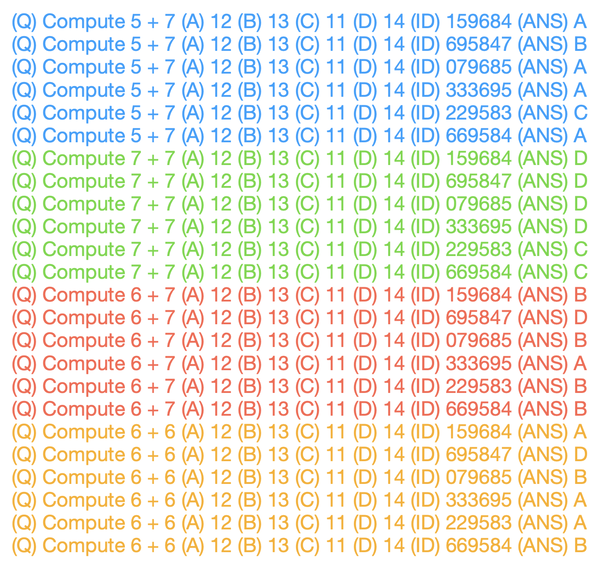

From this dataset, it is possible to see that the same MCQ is present multiple times in the dataset, as multiple students attempted to answer. If never_seen_MCQ = False (first method explained), this is a possible splitting between the training dataset and the validation dataset (train_ratio = 0.75):

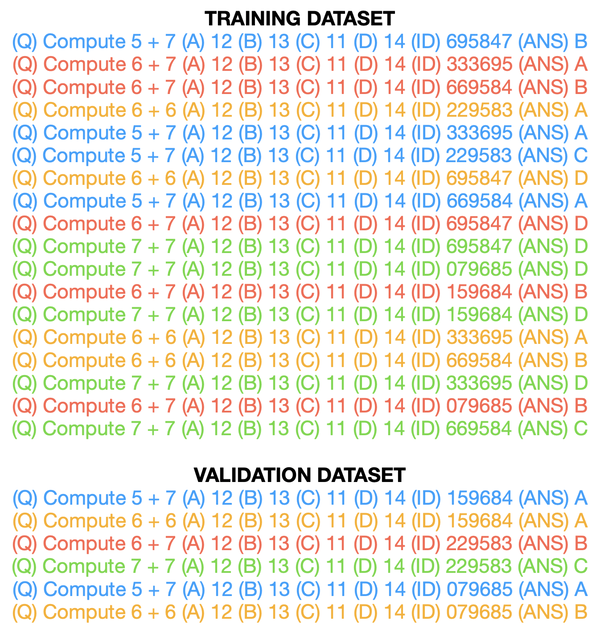

As expected, the dataset is split line by line, and each dataset can contain the same question, but for different students. If, instead, we set never_seen_MCQ = True (second method explained), this is a possible splitting between the training dataset and the validation dataset (train_ratio = 0.75):

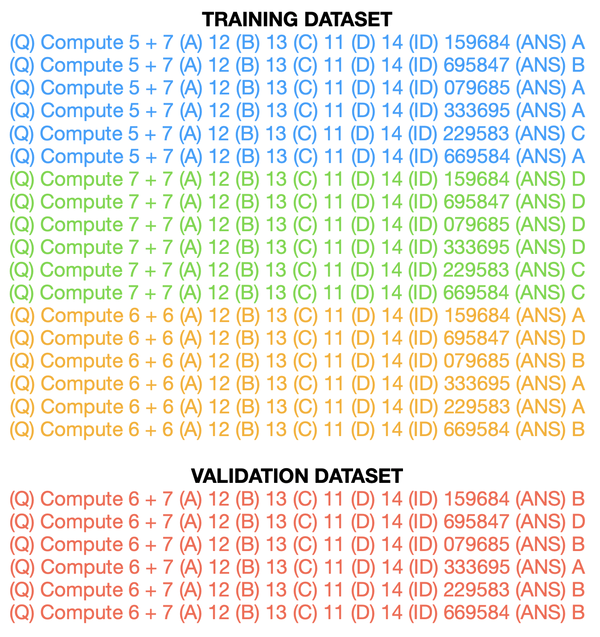

In this case, each question is appearing only in the training dataset or in the validation dataset, and the model will be evaluated on its ability to predict the student's answers to a question which it has never seen before.

In [7]:
if never_seen_MCQ == False:
    # Splitting by row
    data_train, data_val = train_test_split(data, train_size = train_ratio, random_state = seed)
else:
    # Splitting by question
    unique_questions = data['question'].unique()
    discrepancy = 1.0
    data_train = pd.DataFrame()
    data_val = pd.DataFrame()
    add_seed = 0
    # Splitting until the actual train ratio is close enough to the desired one (within splitting_tolerance)
    while abs(discrepancy) > splitting_tolerance:
        # Splitting the unique questions
        train_questions, val_questions = train_test_split(unique_questions, train_size = train_ratio, random_state = seed + add_seed)
        # Determining which rows are in the train and validation sets
        data_train = data[data['question'].isin(train_questions)]
        data_val = data[data['question'].isin(val_questions)]
        # Calculating the actual train ratio
        total_rows = len(data_train) + len(data_val)
        actual_train_ratio = len(data_train) / total_rows
        # Calculating the discrepancy
        discrepancy = actual_train_ratio - train_ratio
        add_seed = add_seed + 1
    print(f"Actual train ratio: {actual_train_ratio}")

print(f"Training set size: {len(data_train)}")
print(f"Validation set size: {len(data_val)}")

Training set size: 109965
Validation set size: 27492


At this point, we define the model 'MCQBert1' (see scheme below), in which the embeddings of the students are concatenated just before the classification layer.

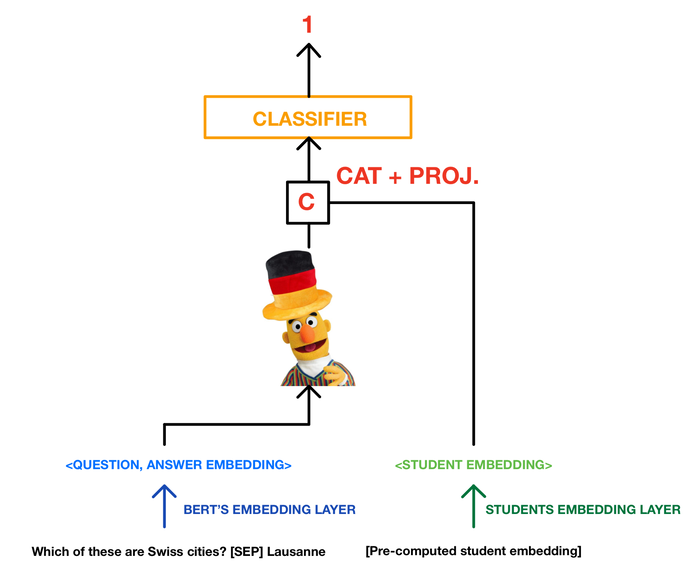

In [8]:
# Embeddings concatenated just before the classification layer
class MCQBert1(BertModel):
    def __init__(self, config, student_embedding_size):
        super().__init__(config)
        self.student_embedding_layer = torch.nn.Linear(student_embedding_size, config.hidden_size)
        
    def forward(self, input_ids, student_embeddings):
        output = super().forward(input_ids)
        output_with_student_embedding = torch.cat((output.last_hidden_state[:, 0, :], self.student_embedding_layer(student_embeddings)), dim = 1)
        return output_with_student_embedding

We now define the model 'MCQBert3' (see scheme below), in which the embeddings are summed at the input of the model.

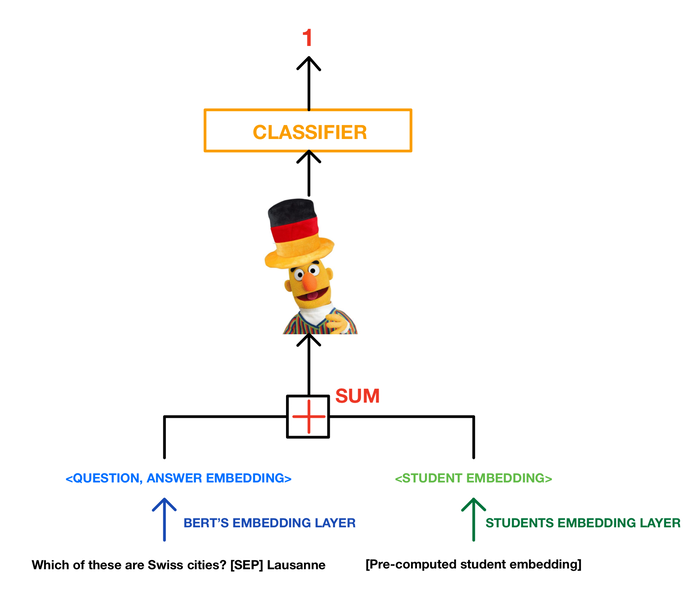

In [9]:
# Embeddings summed at the input of the model
class MCQBert3(BertModel):
    def __init__(self, config, student_embedding_size):
        super().__init__(config)
        self.student_embedding_layer = torch.nn.Linear(student_embedding_size, config.hidden_size)
        
    def forward(self, input_ids, student_embeddings):
        input_embeddings = self.embeddings(input_ids)
        combined_embeddings = input_embeddings + self.student_embedding_layer(student_embeddings).unsqueeze(1).repeat(1, input_embeddings.size(1), 1)
        output = super().forward(inputs_embeds = combined_embeddings)
        return output.last_hidden_state[:, 0, :]

The scheme below shows the complete architecture of the models we considered (the embeddings are not depicted in this case):

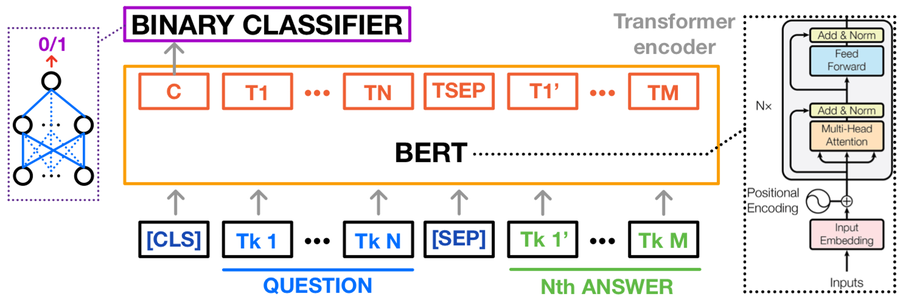

As indicated in the previous milestone (and in the notebook for the second step of our pipeline), we decided to frame the MCQs prediction problem as a binary classification problem. More in detail, we split each datapoint into multiple datapoints, each of them containing the question and one of the possible answers. The objective of the model is to predict 1 if the student selected that possible answer and to predict 0 if the student did not select that possible answer. This concept is further clarified in the scheme below. 

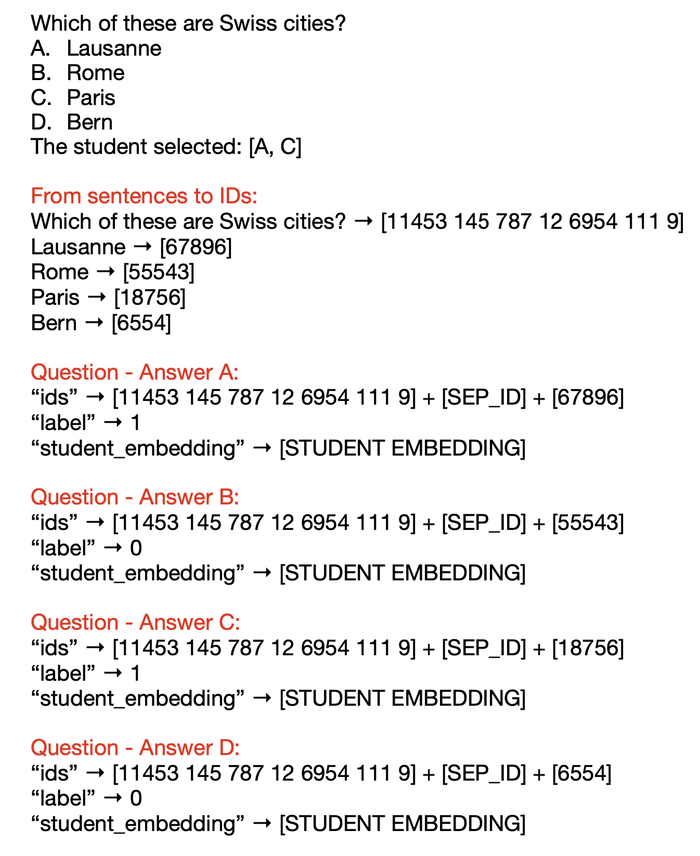

We now define the complete models, which include a classifier head (two linear layers with a ReLU activation in between) so that the model can predict whether each of the possible answers has been selected by the student or not. It should be noted that each of the models is based on LernnaviBERT finetuned on the correct answer prediction (see step 2), which we download from the HuggingFace hub. Furthermore, we also finetune a baseline model, which do not contain the embeddings of the students.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hidden_layer_size = 256 # Size of the hidden layer in the classifier
embedding_size = 4096 # Size of the student embedding

# Tokenizer
tok_model_name = "dbmdz/bert-base-german-uncased"
tokenizer = AutoTokenizer.from_pretrained(tok_model_name)

# Baseline model, based on BertModel (baseline model without embeddings)
config_modelB = AutoConfig.from_pretrained(f"tommymarto/LernnaviBERT_baseline_correct_answers_{embedding_size}")
modelB = BertModel(config_modelB)
modelB.classifier = torch.nn.Sequential(
    torch.nn.Linear(modelB.config.hidden_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
modelB.to(device)

# Model 1, based on MCQBert1
config_model1 = AutoConfig.from_pretrained(f"tommymarto/LernnaviBERT_mcqbert1_correct_answers_{embedding_size}")
model1 = MCQBert1(config_model1, embedding_size)
model1.classifier = torch.nn.Sequential(
    torch.nn.Linear(model1.config.hidden_size * 2, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
model1.to(device)

# Model 3, based on MCQBert3
config_model3 = AutoConfig.from_pretrained(f"tommymarto/LernnaviBERT_mcqbert3_correct_answers_{embedding_size}")
model3 = MCQBert3(config_model3, embedding_size)
model3.classifier = torch.nn.Sequential(
    torch.nn.Linear(model3.config.hidden_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, 1)
)
model3.to(device)

MCQBert3(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31102, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
   

At this point, we define the training dataset and the validation/test dataset.

In [11]:
# Training dataset with student embeddings
train_dataset = QuestionsDatasetWithSyncedEmbeddings(tokenizer, data_train)
# Validation dataset with student embeddings
dev_dataset = QuestionsDatasetWithSyncedEmbeddings(tokenizer, data_val)

109965it [00:49, 2234.44it/s]
27492it [01:20, 342.40it/s]


We now perform the training of the baseline model, evaluating it on a separate dataset.

--- MODEL B - Baseline ---
--- No student embeddings ---


Evaluation: 100%|██████████| 6738/6738 [01:53<00:00, 59.45it/s]


Epoch: 0
Training loss: 0.664
Validation loss: 0.568
Accuracy score: 0.785
F1 score for class 0: 0.816
F1 score for class 1: 0.740
Confusion matrix:
[[51521 12181]
 [11041 33062]]
MCC: 0.556


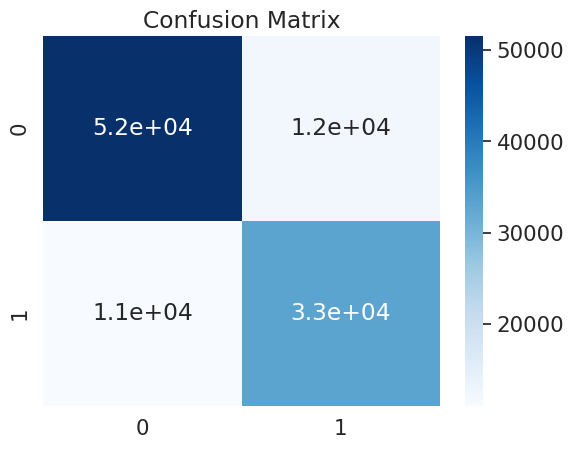

Evaluation: 100%|██████████| 6738/6738 [04:59<00:00, 22.53it/s]


Epoch: 1
Training loss: 0.571
Validation loss: 0.560
Accuracy score: 0.791
F1 score for class 0: 0.827
F1 score for class 1: 0.735
Confusion matrix:
[[53994  9708]
 [12813 31290]]
MCC: 0.564


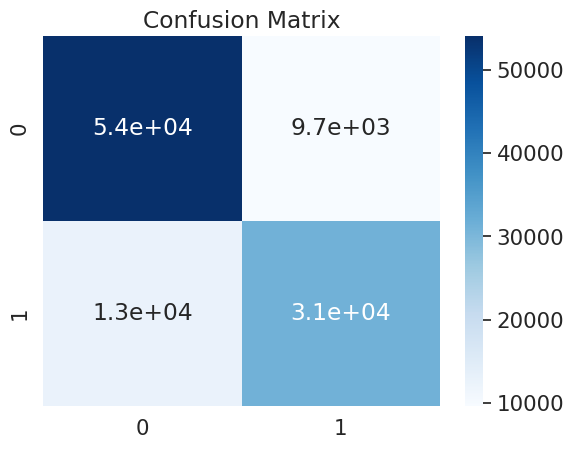

Evaluation: 100%|██████████| 6738/6738 [01:57<00:00, 57.23it/s]


Epoch: 2
Training loss: 0.561
Validation loss: 0.543
Accuracy score: 0.794
F1 score for class 0: 0.827
F1 score for class 1: 0.745
Confusion matrix:
[[53232 10470]
 [11729 32374]]
MCC: 0.572


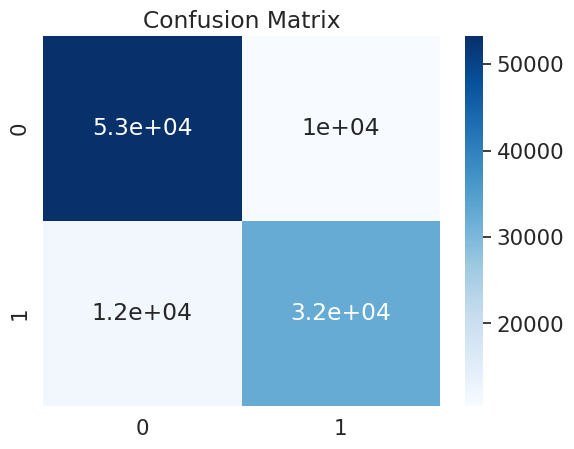

model.safetensors:   0%|          | 0.00/441M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tommymarto/LernnaviBERT_baseline_students_answers_4096_mistral_seq_len_10/commit/0fd97d025b004ccbed1756629ad73fc4b44c10b2', commit_message='Upload model', commit_description='', oid='0fd97d025b004ccbed1756629ad73fc4b44c10b2', pr_url=None, pr_revision=None, pr_num=None)

In [16]:
print("--- MODEL B - Baseline ---")
print("--- No student embeddings ---")
bert_model_name = "baseline"
train(modelB, train_dataset, dev_dataset, device, epochs, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=False)

modelB.push_to_hub("tommymarto/LernnaviBERT_"+bert_model_name+f"_students_answers_4096_mistral_seq_len_{seq_len}")

Then, we perform the training of the model 'MCQBert1', again evaluating it on a separate dataset.

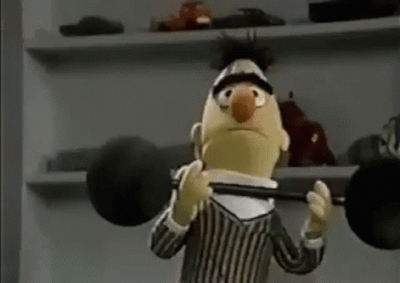

[Source of the image: https://tenor.com/en-GB/view/sesame-street-bert-ernie-exercise-gym-work-out-gif-17243877]

--- MODEL 1 - MCQBert1 ---
--- Student embeddings concatenated just before the classification layer ---


Evaluation: 100%|██████████| 6738/6738 [01:54<00:00, 58.80it/s]


Epoch: 0
Training loss: 0.662
Validation loss: 0.558
Accuracy score: 0.785
F1 score for class 0: 0.822
F1 score for class 1: 0.727
Confusion matrix:
[[53694 10008]
 [13169 30934]]
MCC: 0.551


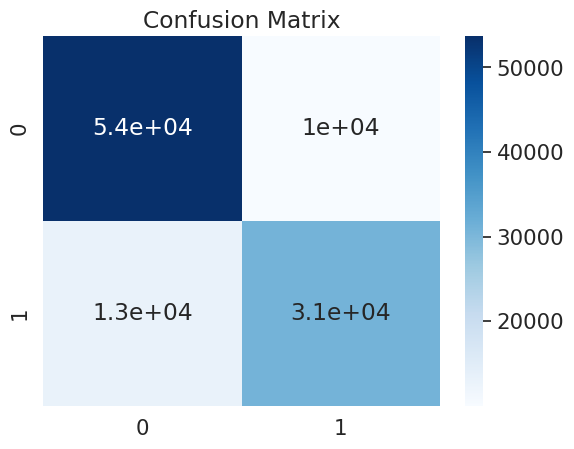

Evaluation: 100%|██████████| 6738/6738 [01:55<00:00, 58.54it/s]


Epoch: 1
Training loss: 0.563
Validation loss: 0.561
Accuracy score: 0.792
F1 score for class 0: 0.825
F1 score for class 1: 0.744
Confusion matrix:
[[52929 10773]
 [11621 32482]]
MCC: 0.569


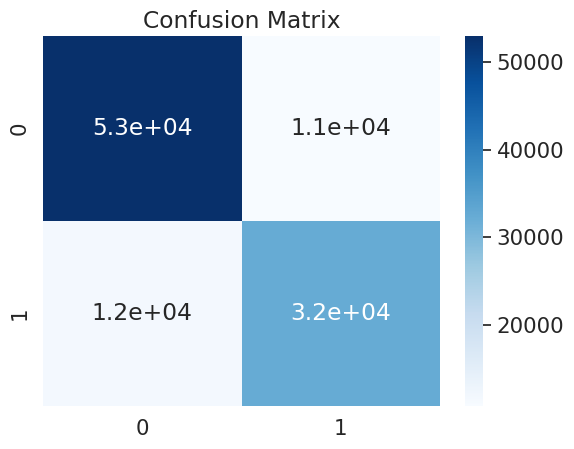

Evaluation: 100%|██████████| 6738/6738 [02:01<00:00, 55.46it/s]


Epoch: 2
Training loss: 0.556
Validation loss: 0.578
Accuracy score: 0.773
F1 score for class 0: 0.802
F1 score for class 1: 0.734
Confusion matrix:
[[49616 14086]
 [10361 33742]]
MCC: 0.538


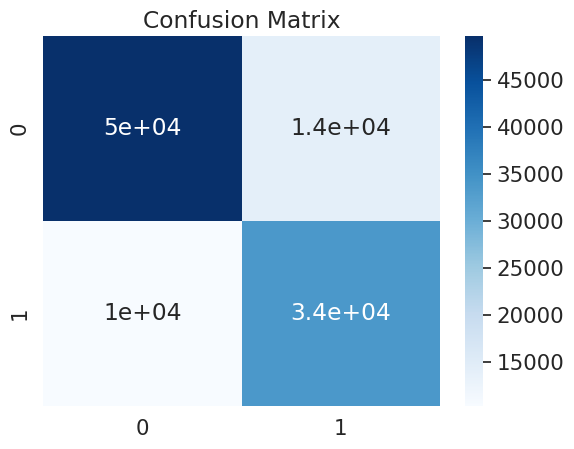

model.safetensors:   0%|          | 0.00/454M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tommymarto/LernnaviBERT_mcqbert1_students_answers_4096_mistral_seq_len_10/commit/3eaf88f322de7bbf3b2a308237621ce030fd5e60', commit_message='Upload MCQBert1', commit_description='', oid='3eaf88f322de7bbf3b2a308237621ce030fd5e60', pr_url=None, pr_revision=None, pr_num=None)

In [17]:
print("--- MODEL 1 - MCQBert1 ---")
print("--- Student embeddings concatenated just before the classification layer ---")
bert_model_name = "mcqbert1"
train(model1, train_dataset, dev_dataset, device, epochs, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=True)

model1.push_to_hub("tommymarto/LernnaviBERT_"+bert_model_name+f"_students_answers_4096_mistral_seq_len_{seq_len}")

Finally, we perform the training of the model 'MCQBert3', evaluating it on a separate dataset.

--- MODEL 3 - MCQBert3 ---
--- Student embeddings summed at the input of the model ---


Evaluation: 100%|██████████| 6738/6738 [01:55<00:00, 58.19it/s]


Epoch: 0
Training loss: 0.702
Validation loss: 0.582
Accuracy score: 0.781
F1 score for class 0: 0.822
F1 score for class 1: 0.715
Confusion matrix:
[[54496  9206]
 [14437 29666]]
MCC: 0.541


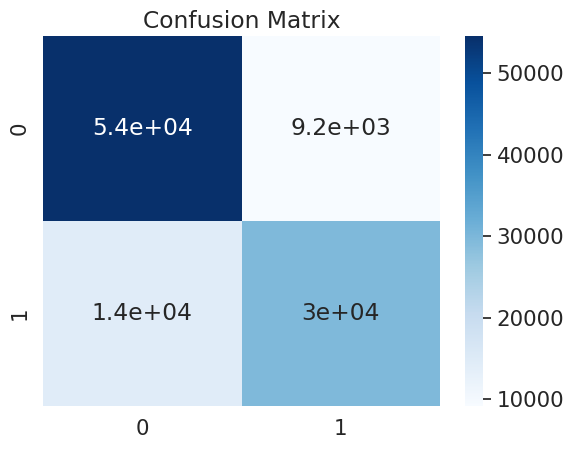

Evaluation: 100%|██████████| 6738/6738 [02:21<00:00, 47.49it/s]


Epoch: 1
Training loss: 0.576
Validation loss: 0.553
Accuracy score: 0.788
F1 score for class 0: 0.817
F1 score for class 1: 0.746
Confusion matrix:
[[51235 12467]
 [10417 33686]]
MCC: 0.564


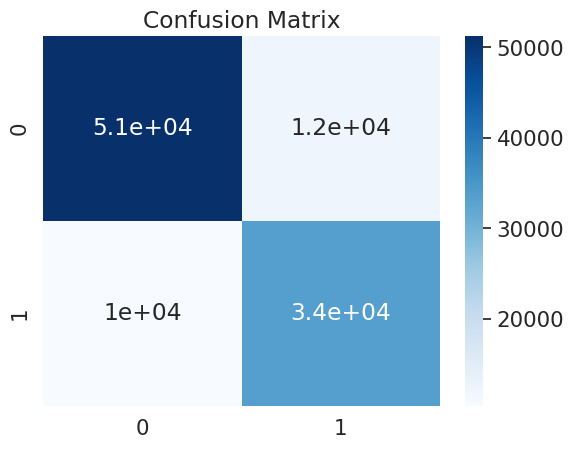

Evaluation: 100%|██████████| 6738/6738 [01:55<00:00, 58.16it/s]


Epoch: 2
Training loss: 0.563
Validation loss: 0.556
Accuracy score: 0.790
F1 score for class 0: 0.819
F1 score for class 1: 0.752
Confusion matrix:
[[51007 12695]
 [ 9911 34192]]
MCC: 0.571


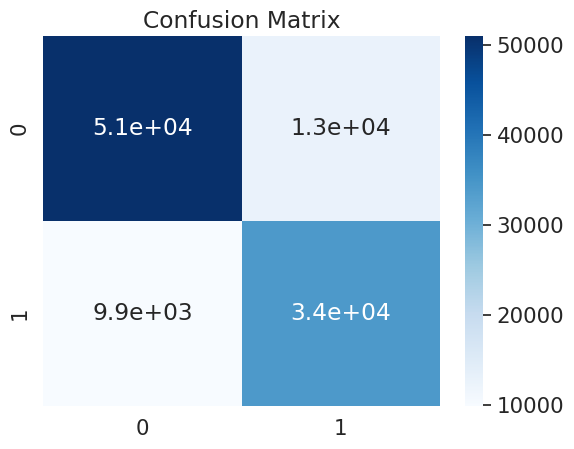

model.safetensors:   0%|          | 0.00/453M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tommymarto/LernnaviBERT_mcqbert3_students_answers_4096_mistral_seq_len_10/commit/b8d1e98ab9adb5eecb3f35dc0c54464e803ddeb8', commit_message='Upload MCQBert3', commit_description='', oid='b8d1e98ab9adb5eecb3f35dc0c54464e803ddeb8', pr_url=None, pr_revision=None, pr_num=None)

In [12]:
print("--- MODEL 3 - MCQBert3 ---")
print("--- Student embeddings summed at the input of the model ---")
bert_model_name = "mcqbert3"
train(model3, train_dataset, dev_dataset, device, epochs, batch_size,
      learning_rate, warmup_p, max_gradient_norm, embedding_required=True)

model3.push_to_hub("tommymarto/LernnaviBERT_"+bert_model_name+f"_students_answers_4096_mistral_seq_len_{seq_len}")

For all the three models considered, the epoch in which they reach the best performance is the second one (the performance slightly decreases in the third training epoch for all the models). We will therefore discuss the results reached at the end of the second epoch. From the results listed above, we can notice that both MCQBert1 and MCQBert3 ourperforms the baseline model both in terms of the average F1 score and of the MCC. In particular, the percentual improvements over the baseline are the following:

- MCQBert1: +1.43% over the baseline on the average F1 score, +3.86% over the baseline on the MCC;
- MCQBert3: +1.88% over the baseline on the average F1 score, +4.78% over the baseline on the MCC.

Therefore, the embeddings seem beneficial for the task we aim at performing, as the performance improvement over the baseline is quite significant. However, it should be noted that these results tend to slightly oscillate from run to run, and a more extensive evaluation would be necessary to draw more precise conclusions. Since training the models is computationally very expensive, we were limited in the amount of times a complete training could be performed. In any case, the models seem to be able to exploit the additional information received in the form of student embeddings to refine the prediction, and to reach better results than the baseline model (in which the embeddings are not considered). Therefore, our approach seems very promising in obtaining a model able to predict which answers of MCQs will be selected by a student. This can be noticed also by considering the absolute results instead of the relative ones: at the second epoch, MCQBert1 got an average F1 score of 0.781, while MCQBert3 got an average F1 score of 0.7845, which are quite high for a complex task such as the one we are considering.

An interesting, and perhaps surprising, aspect is that the model which obtained the best results was MCQBert3, the one which obtained the worst results on the second experiment of the second step (i.e. remembering the correct answers to MCQs). This may signify that knowing the correct answers of MCQs is not necessarily improving the prediction capabilities of the models.